In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import glob

In [2]:
nx = 9
ny = 6

In [3]:
# populating imgpoints and objpoints

cal_imgs = glob.glob('camera_cal/calibration*.jpg')

objpt = np.zeros((6*9, 3), np.float32)
objpt[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

objpoints = []
imgpoints = []

for cal_img in cal_imgs:
    
    # loading chess image
    chess_img = cv2.imread(cal_img)

    # converting to gray scale
    chess_img_gray = cv2.cvtColor(chess_img, cv2.COLOR_BGR2GRAY)

    # finding chess corners
    ret, corners = cv2.findChessboardCorners(chess_img_gray, (nx, ny), None)

    # appending to objpoints and imgpoints
    if ret == True:
        objpoints.append(objpt)
        imgpoints.append(corners)

In [4]:
img = cv2.imread('test_images/test1.jpg')

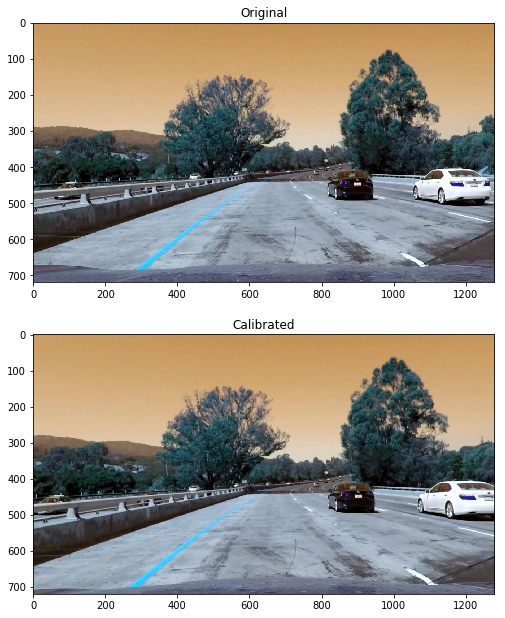

In [5]:
def calibrate(img):
    
    # loading target image
    img_copy = np.copy(img)

    # converting to gray scale
    img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)

    # undistorting the image
    ret, mtx, dist, rvects, tvects = cv2.calibrateCamera(objpoints, imgpoints, img_gray.shape[::-1], None, None)
    img_undistorted = cv2.undistort(img_copy, mtx, dist, None, mtx)
    
    return img_undistorted

fig, ax = plt.subplots(2)
fig.set_size_inches(30, 10.5)

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')
test_img = calibrate(img)
ax[1].set_title('Calibrated')
ax[1].imshow(test_img, cmap='gray')

In [6]:
M, Minv = None, None

def warp(img):
    
    global M, Minv
    
    # copying the target image
    img_copy = np.copy(img)
    
    src = np.float32([[240, 720], 
                      [590, 450], 
                      [690, 450], 
                      [1060, 720]])
   
    dst = np.float32([[240, 720], 
                  [260, 0], 
                  [1080, 0], 
                  [1060, 720]])
    
    # computing the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # computing the inverse perspective transform matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # warping the image
    warped = cv2.warpPerspective(img_copy, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
    return warped

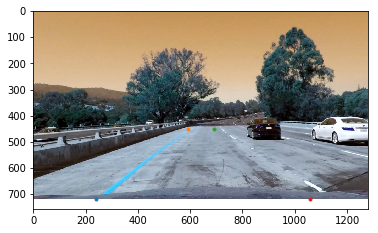

In [7]:
img_undistorted = calibrate(img)

# plotting the points

plt.imshow(img_undistorted)
plt.plot(240, 720, '.')
plt.plot(590, 450, '.')
plt.plot(690, 450, '.')
plt.plot(1060, 720, '.')

In [8]:
def abs_sobel(img, orient='x', thresh=(0, 255)):
    
    # copying the target image
    img_copy = np.copy(img)
    
    # converting to grayscale
    img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    
    # applying sobel operator to x and y direction
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img_gray, cv2.CV_64F, 1, 0))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img_gray, cv2.CV_64F, 0, 1))
    
    # scaling the output
    abs_sobel_scaled = np.uint8(255 * abs_sobel / np.max(abs_sobel))
        
    # defining the binary image and applying thresholds 
    s_binary = np.zeros_like(abs_sobel_scaled)
    s_binary[(abs_sobel_scaled>=thresh[0]) & (abs_sobel_scaled<=thresh[1])] = 1

    return s_binary

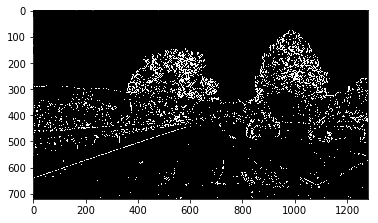

In [9]:
s_abs_x = abs_sobel(img, orient='x', thresh=(20, 80))
s_abs_y = abs_sobel(img, orient='y', thresh=(20, 100))
plt.imshow(s_abs_x, cmap='gray')

In [10]:
def mag_sobel(img, sobel_kernel=3, thresh=(0, 255)):
    
    # copying the target image
    img_copy = np.copy(img)
    
    # converting to grayscale
    img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    
    # applying sobel operator to x and y direction
    sobel_x = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # calculating magnitude
    sobel_mag = np.sqrt(sobel_x*sobel_x + sobel_y*sobel_y)
    scale = np.max(sobel_mag) / 255
    
    # scaling the output
    sobel_mag_scaled = (sobel_mag / scale).astype(np.uint8)

    # defining the binary image and applying thresholds 
    s_binary = np.zeros_like(sobel_mag_scaled)
    s_binary[(sobel_mag_scaled>=thresh[0]) & (sobel_mag_scaled<=thresh[1])] = 1

    return s_binary

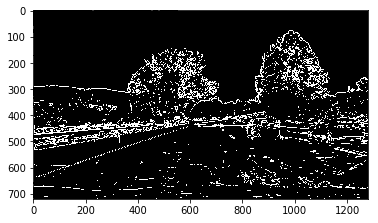

In [11]:
s_mag = mag_sobel(img, sobel_kernel=5, thresh=(30, 100))
plt.imshow(s_mag, cmap='gray')

In [12]:
def dir_sobel(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # copying the target image
    img_copy = np.copy(img)
    
    # converting to grayscale
    img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    
    # applying sobel operator to x and y direction
    sobel_x = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # calcuting directional value
    sobel_dir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
        
    # defining the binary image and applying thresholds 
    s_binary = np.zeros_like(sobel_dir)
    s_binary[(sobel_dir>=thresh[0]) & (sobel_dir<=thresh[1])] = 1

    return s_binary

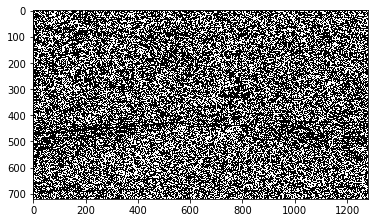

In [13]:
# img = cv2.imread('test_images/straight_lines1.jpg')
s_dir = dir_sobel(img, sobel_kernel=3, thresh=(0.7, 1.3))
plt.imshow(s_dir, cmap='gray')

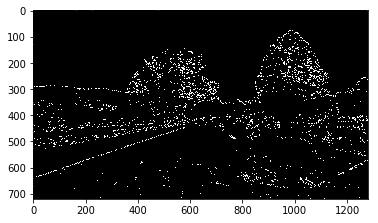

In [14]:
# combining all thresholds

combined = np.zeros_like(s_mag)
combined[((s_abs_x == 1) & (s_abs_y == 1)) | ((s_mag == 1) & (s_dir == 1))] = 1
plt.imshow(combined, cmap='gray')

In [15]:
def hls_select(img, thresh=(0, 255), channel='s'):
    
    # copying the target image
    img_copy = np.copy(img)
    
    # converting to HLS colorspace
    img_hls = cv2.cvtColor(img_copy, cv2.COLOR_BGR2HLS)
    
    # separating the H and S channel
    if channel == 'h':
        s_channel = img_hls[:, :, 0]
    else:
        s_channel = img_hls[:, :, 2]
        
    # defining the binary image and applying thresholds 
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel>thresh[0]) & (s_channel<=thresh[1])] = 1
    
    return s_binary

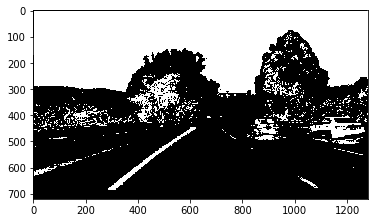

In [16]:
# img = cv2.imread('test_images/straight_lines1.jpg')

# applying threshold to H and S channels

hls_s = hls_select(img, thresh=(90, 255), channel='s')
hls_h = hls_select(img, thresh=(15, 100), channel='h')
plt.imshow(hls_s, cmap='gray')

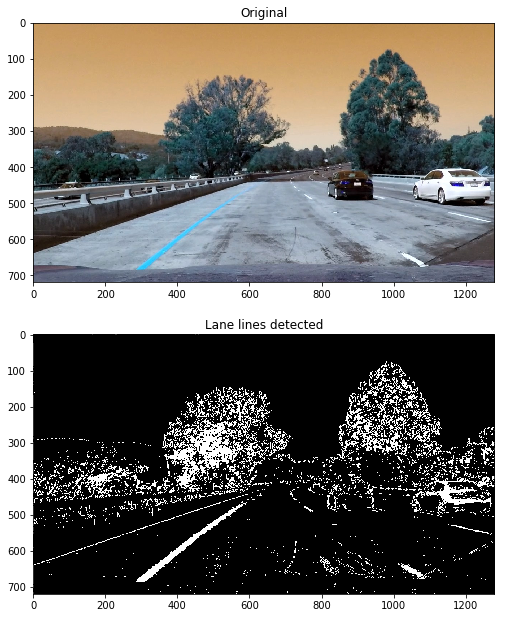

In [17]:
# combining s_abs_x threshold, H and S channel thresholds as the final choosen options

combined = np.zeros_like(hls_s)
combined[((hls_s == 1) & (hls_h == 1)) | (s_abs_x == 1)] = 1

fig, ax = plt.subplots(2)
fig.set_size_inches(30, 10.5)

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')
test_img = calibrate(img)
ax[1].set_title('Lane lines detected')
ax[1].imshow(combined, cmap='gray')

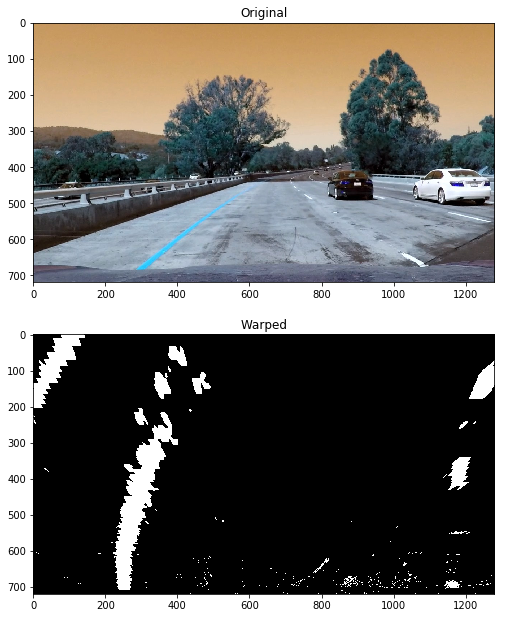

In [18]:
# plotting the warped image

warped = warp(combined)

fig, ax = plt.subplots(2)
fig.set_size_inches(30, 10.5)

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')
test_img = calibrate(img)
ax[1].set_title('Warped')
ax[1].imshow(warped, cmap='gray')

In [19]:
def region_of_interest(img, vertices):
    
    # copying the target image
    img_copy = np.copy(img)
    
    # converting to grayscale
    mask = np.zeros_like(img_copy)
    
    # setting the mask based on the number of channels in the target image
    if len(mask.shape) > 2:
        channel_count = mask.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    # filling the polynomial
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # bitwising the image and the mask
    masked_image = np.bitwise_and(img, mask)
    
    return masked_image

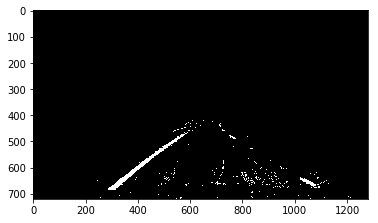

In [20]:
# applying region_of_interest to the image

vertices = np.array([[(130, img.shape[0]), (600, 420), (700, 420), (img.shape[1], img.shape[0])]])
roi = region_of_interest(combined, vertices)
plt.imshow(roi, cmap='gray')

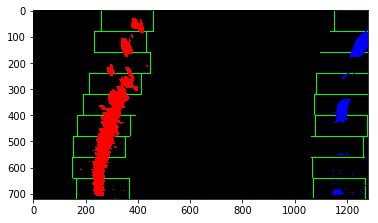

In [21]:
def find_lane_pixels(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    nwindows = 9
    margin = 100
    minpix = 50

    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin  
        win_xright_low = rightx_current - margin  
        win_xright_high = rightx_current + margin  
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window 
        good_left_inds = (
            (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & 
            (nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high)
        ).nonzero()[0]
        good_right_inds = (
            (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & 
            (nonzerox >= win_xright_low) & (nonzerox <= win_xright_high)
        ).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window 
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit, out_img

left_fitx, right_fitx, ploty, left_fit, right_fit, out_img = fit_polynomial(warped)

plt.imshow(out_img)
plt.show()

In [22]:
def draw_lanes(out_img, warped, left_fitx, right_fitx, ploty):
    
    # output image to draw the lines
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_pts = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((left_pts, right_pts))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(out_img, 1, newwarp, 0.3, 0)
    
    return result

In [23]:
# res = draw_lanes(warped)
# plt.imshow(res)

In [24]:
def calc_radius(out_img, img, left_fit, right_fit):

    xm_per_pix = 3.7 / 700
    ym_per_pix = 30 / 720
    
    # copying the target image
    img_copy = np.copy(img)
    
    # calculating leftx, rightx
    y_pts = np.linspace(0, img.shape[0]-1, img.shape[0] )
    leftx = left_fit[0]*y_pts**2 + left_fit[1]*y_pts + left_fit[2]
    rightx = right_fit[0]*y_pts**2 + right_fit[1]*y_pts + right_fit[2]

    # fitting the polynomial
    left_fit_cr = np.polyfit(y_pts*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(y_pts*ym_per_pix, rightx*xm_per_pix, 2)

    y_eval = np.max(y_pts)
    
    # calculating the left and right radius
    left_curverad = round(((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0]), 2)
    right_curverad = round(((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0]), 2)
#     print(left_curverad, right_curverad)
    
    # calculating offset of the car from center
    left_x = left_fit[0]*img.shape[0]**2 + left_fit[1]*img.shape[0] + left_fit[2]
    right_x = right_fit[0]*img.shape[0]**2 + right_fit[1]*img.shape[0] + right_fit[2]
    pos = (left_x + right_x) / 2
    distance_from_center = round(abs(img.shape[1]/2 - pos) * (xm_per_pix), 2)
    
    # referenced below code from https://www.geeksforgeeks.org/python-opencv-cv2-puttext-method/
    font = cv2.FONT_HERSHEY_SIMPLEX 
  
    # org 
    y0, dy = 50, 100

    # fontScale 
    fontScale = 3

    # Blue color in BGR 
    color = (255, 0, 0) 

    # Line thickness of 2 px 
    thickness = 2
    
    # left and right radius
    text = 'Left Radius: ' + str(left_curverad) + '\nRight Radius: ' + str(right_curverad) + '\nOffset: ' + str(distance_from_center)
    
    for i, txt in enumerate(text.split('\n')):
        y = y0 + i*dy
        cv2.putText(out_img, txt, (150, y), font, fontScale, color, thickness)
    
    return out_img

In [25]:
# final pipeline for processing the images

def process_image(img):
    
    img_undistorted = calibrate(img)
    s_abs_x = abs_sobel(img_undistorted, orient='x', thresh=(20, 80))
    hls_s = hls_select(img_undistorted, thresh=(90, 255), channel='s')
    hls_h = hls_select(img_undistorted, thresh=(15, 100), channel='h')
    combined = np.zeros_like(hls_s)
    combined[((hls_s == 1) & (hls_h == 1)) | (s_abs_x == 1)] = 1
    warped = warp(combined)    
    left_fitx, right_fitx, ploty, left_fit, right_fit, out_img = fit_polynomial(warped)
#     left_fitx, right_fitx, ploty = search_around_poly(warped, left_fit, right_fit)
    result = draw_lanes(img, warped, left_fitx, right_fitx, ploty)
    output = calc_radius(result, combined, left_fit, right_fit)
    
    return output

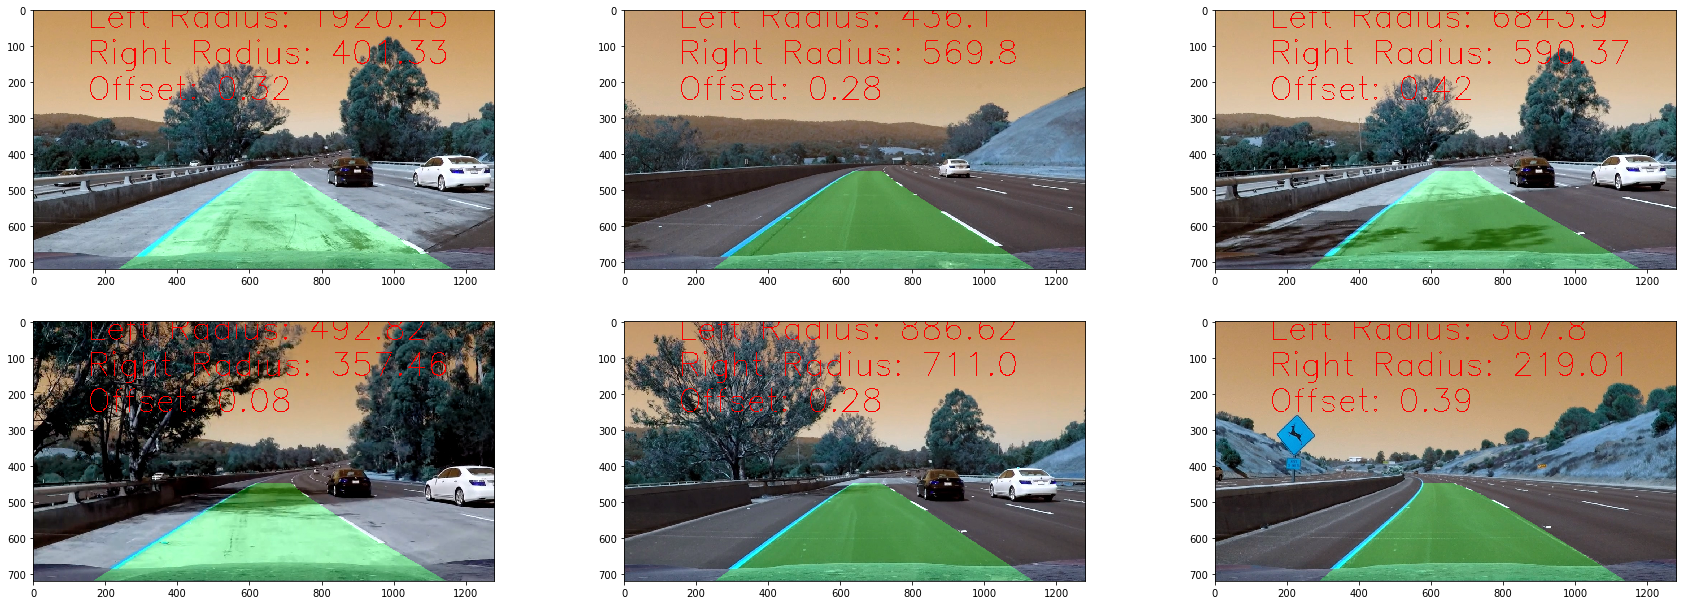

In [26]:
# testing the pipeline on the images in test_images/ folder

imgs = glob.glob('test_images/test*.jpg')
columns = 4
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(30, 10.5)

for i, img in enumerate(imgs):
    image = cv2.imread(img)
    output = process_image(image)
    ax[i//3, i%3].imshow(output, cmap='gray')

In [27]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_videos_output/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [22:57<00:01,  1.09s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 20min 32s, sys: 10.8 s, total: 20min 43s
Wall time: 23min


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>/
""".format(white_output))